## Getting Data Together into arrays

In [25]:
# Import packages
import os, json
import numpy as np
from nltk.stem.snowball import EnglishStemmer
import matplotlib.pyplot as plt

The dataset has been downloaded already, but it needs to be imported from the JSON objects.

In [20]:
#Importing Data
skip = True
title = []
text = []
url = []
labels = []

for x in os.walk("fakenewsnet_dataset/politifact/fake"):
    if skip:
        skip = False
        continue
    try:
        dir = x[0] + "/news content.json"
        dir = dir.replace("\\","/")
        o = json.load(open(dir))
        if o["text"] != "":
            title.append(o["title"])
            text.append(o["text"])
            url.append(o["url"])
            labels.append(1)
    except Exception:
        continue


skip = True
for x in os.walk("fakenewsnet_dataset/politifact/real"):
    if skip:
        skip = False
        continue
    try:
        dir = x[0] + "/news content.json"
        dir = dir.replace("\\","/")
        o = json.load(open(dir))
        if o["text"] != "":
            title.append(o["title"])
            text.append(o["text"])
            url.append(o["url"])
            labels.append(0)
    except Exception:
        continue

## Preprocessing Data

The TFIDF vectorizer handles a lot of the preprocessing, but it does not stem words, so that will be done using Natural Language Toolkit.

In [ ]:

# nltk.download('stopwords')
# nltk.download('punkt')
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk import ngrams


In [ ]:
##CURRENTLY NOT USED
# def n_gram_tokenize(text, n):
#     tokenized_text = text[:]
#     stemmer = EnglishStemmer()
#     ngram_text = []
#     for i in range(len(text)):
#         tokenized_text[i] = re.sub(r'[^A-Za-z ]+',' ',tokenized_text[i]).lower()
#         tokenized_text[i] = [word for word in word_tokenize(tokenized_text[i]) if not word in stop_words]
#         tokenized_text[i] = [stemmer.stem(word) for word in tokenized_text[i]]
#         ngram_text.append(list(ngrams(tokenized_text[i],n)))
#     return tokenized_text, ngram_text

In [ ]:
# tokenized_text, ngram_text = n_gram_tokenize(text,1)

In [ ]:
# arr = np.array([title,url,text,tokenized_text,ngram_text,label],dtype=object).T
# np.save("Pre-Processed Data",arr)
# dataset = pd.DataFrame(data=arr,columns=["Title","URL","Original Text","Tokenized Text","N-gram Text","Label"])
# dataset['Label'] = dataset['Label'].astype(int)

In [21]:
#Stemming using the english stemmer
stemmer = EnglishStemmer()
stemmed_text = text[:]
stemmed_title = title[:]
for i in range(len(text)):
    stemmed_text[i] = ' '.join([stemmer.stem(word) for word in text[i].split(" ")])
    stemmed_title[i] = ' '.join([stemmer.stem(word) for word in title[i].split(" ")])
    stemmed_text[i] = stemmed_title[i] + stemmed_text[i]

## Tuning Hyperparameters
The hyperparameter to be tuned is the range of n-grams to use for the vectorizer. For example, a range of (1,3) means that the model is trained on uni-grams, bi-grams, and tri-grams. A range of (1,1) would mean the model only takes into account uni-grams, or just words by themselves.

In [22]:
#Loading data
stemmed_text = np.array(stemmed_text)
labels = np.array(labels)

In [23]:
#Train test split
from sklearn.model_selection import train_test_split

seed = 42
X_train, X_test, y_train, y_test = train_test_split(stemmed_text,labels,test_size=0.3,random_state=seed)

#Sanity check
X_train.shape

(571,)

The functions below were used for cross-validation. Stochastic Gradient Descent with a linear SVM loss function was used to classify in cross-validation. Any classifier could be used since performance within a classifier would be appropriate to test the difference in accuracy with different n-gram usage.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

def FeatureExtraction(X_train, X_test,m,n,max_df=0.5,min_df=10):

    #Feature extraction
    vectorizer = TfidfVectorizer(strip_accents='unicode',stop_words='english',lowercase=True,token_pattern=r'\b[a-zA-Z]{3,}\b',ngram_range=(m,n),max_df = max_df,min_df=min_df)
    X_train_features = vectorizer.fit_transform(X_train)
    
    #Transforming validation set
    X_test_features = vectorizer.transform(X_test)
    
    return X_train_features, X_test_features
    
def Classify(X_train_features,X_test_features,y_train,method='SGD'):

    #Training classifier
    if method == 'SGD':
        classifier = SGDClassifier(loss='hinge',n_jobs=-1,random_state=seed)
    elif method == 'Logistic':
        classifier = LogisticRegression(n_jobs=-1,random_state=seed)
    elif method == 'LinearSVM':
        classifier = SVC(random_state=seed,kernel='linear')
    elif method == 'PolySVM':
        classifier = SVC(random_state=seed,kernel='poly')
    elif method == 'Perceptron':
        classifier = Perceptron(n_jobs=-1,random_state=seed)
    else:
        raise Exception("Unsupported method passed")
        
    classifier.fit(X_train_features,y_train)

    #Predicting training set
    pred_train_labels = classifier.predict(X_train_features)

    #Predicting test set
    pred_test_labels = classifier.predict(X_test_features)

    return pred_train_labels, pred_test_labels

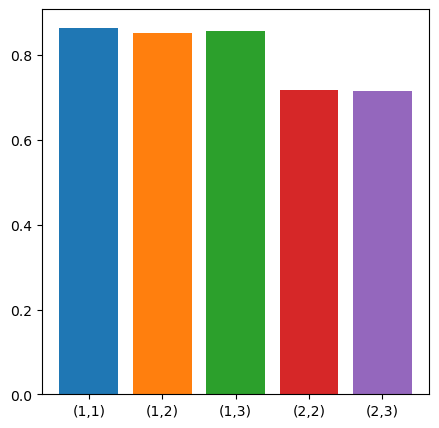

In [31]:
#Stratified cross-validation for tuning of n-gram range
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

bestScore = 0
bestM = 0
bestN = 0

figure = plt.figure(figsize=(5,5))

for m in range(1,3):
    for n in range(m,4):
        avgTrain = 0
        avgVal = 0
        k = 1
        for train_i, test_i in kfold.split(X_train,y_train):

            #Getting feature matrices
            X_train_features, X_test_features = FeatureExtraction(X_train[train_i],X_train[test_i],m,n)

            #Classification
            pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train[train_i])

            #Validity metric
            avgTrain += accuracy_score(y_train[train_i],pred_train_labels)
            avgVal += accuracy_score(y_train[test_i],pred_test_labels)

            k += 1

        avgTrain = avgTrain / kfold.get_n_splits()
        avgVal = avgVal / kfold.get_n_splits()

        plt.bar('(%d,%d)' % (m,n),avgVal)

        #Store best
        if avgVal > bestScore:
            bestScore = avgVal
            bestM = m
            bestN = n

plt.title("N-gram Tuning")
plt.xlabel("N-gram range for training")
plt.ylabel("Accuracy")

In [29]:
print("The best n-gram range is (%d,%d)" % (bestM,bestN), "with an average score of %f" % bestScore)

The best n-gram range is (1,1) with an average score of 0.865141


Text(0, 0.5, 'Accuracy')

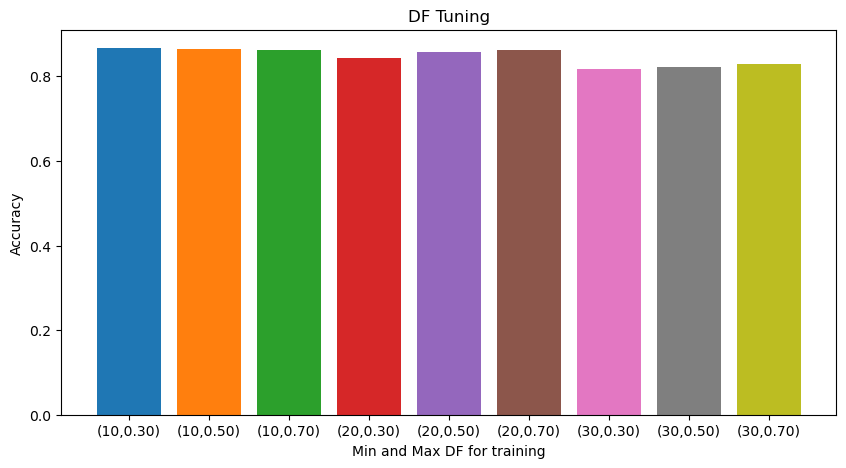

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

m = bestM
n = bestN
bestScore = 0
bestMinDf = 0
bestMaxDf = 0

figure = plt.figure(figsize=(10,5))

for min_df in [10, 20, 30]:
    for max_df in [0.3, 0.5, 0.7]:
        avgTrain = 0
        avgVal = 0
        k = 1
        for train_i, test_i in kfold.split(X_train,y_train):

            #Getting feature matrices
            X_train_features, X_test_features = FeatureExtraction(X_train[train_i],X_train[test_i],m,n,max_df=max_df,min_df=min_df)

            #Classification
            pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train[train_i])

            avgTrain += accuracy_score(y_train[train_i],pred_train_labels)
            avgVal += accuracy_score(y_train[test_i],pred_test_labels)

            k += 1

        avgTrain = avgTrain / kfold.get_n_splits()
        avgVal = avgVal / kfold.get_n_splits()

        plt.bar('(%d,%.2f)' % (min_df,max_df),avgVal)

        if avgVal > bestScore:
            bestScore = avgVal
            bestMinDf = min_df
            bestMaxDf = max_df

plt.title("DF Tuning")
plt.xlabel("Min and Max DF for training")
plt.ylabel("Accuracy")

In [38]:
print("The best min and max df values are %d and %.2f respectively," % (bestMinDf,bestMaxDf), "with an average score of %f" % bestScore)

The best min and max df values are 10 and 0.30 respectively, with an average score of 0.866895


## Training

<BarContainer object of 1 artists>

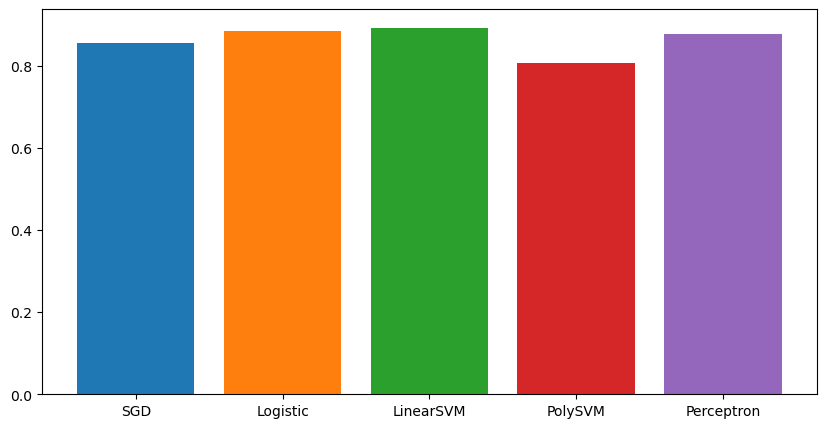

In [43]:
plt.figure(figsize=(10,5))

#Getting feature matrices
X_train_features, X_test_features = FeatureExtraction(X_train,X_test,m,n,max_df=bestMaxDf,min_df=bestMinDf)

#Classification
pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train,method='SGD')
plt.bar('SGD',accuracy_score(y_test,pred_test_labels))
pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train,method='Logistic')
plt.bar('Logistic',accuracy_score(y_test,pred_test_labels))
pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train,method='LinearSVM')
plt.bar('LinearSVM',accuracy_score(y_test,pred_test_labels))
pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train,method='PolySVM')
plt.bar('PolySVM',accuracy_score(y_test,pred_test_labels))
pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train,method='Perceptron')
plt.bar('Perceptron',accuracy_score(y_test,pred_test_labels))
